In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import minimize
from scipy.optimize import fmin
import matplotlib.pyplot as plt
from itertools import chain

import warnings
warnings.filterwarnings("ignore")

import os
if not os.path.exists('plots/'):
    os.mkdir('plots')


In [2]:
# Experimental data for NaCl MIC
NaCl_initial = [0.5 ,1.0, 1.5, 2.0, 2.5] 
NaCl_M = [i*0.1 for i in NaCl_initial]
NaCl_mM = [i*100 for i in NaCl_initial]

# Combine Sattar's Data with different salt concentrations:
NaCl = [0.5 ,1.0, 1.5, 2.0, 2.5] #units 100mM
MIC_NaCl = [ 1.12, 1.25, 1.62 ,1.75, 2 ] #units µM

# Convert NaCl concentration to kappa length
def mol_to_kappa(mM):
    Molar = mM * 10**(-3)  
    kappa = 0.304/np.sqrt(Molar)*10 #Length unit in amstrong
    return 1/ kappa

kappa_range = [mol_to_kappa(mM) for mM in NaCl_mM ]


In [3]:
# Define variables 
Eps         = 8.85e-12;               #Vacuum permittivity(coloum^2/Jm)         
T           = 277;                    #Tempreture (kelvin)
Kb          = 1.38*1e-23;             #Boltzmann Constant (J/kelvin)
Dw          = 80;                     #Water dielectric constant
NA          = 6.023*1e+23;            #Avagadro's number
V           = 1e27;                   #Total volume in (A^3) 
ele         = 1.6e-19;                #Electron Charge
lb          = ele**2*1e+10/(4*np.pi*Eps*Dw*Kb*T);   #% Bejurium Length (A)
V           = 1e27;                   #Total volume in (A^3) 
# D           = 200*10;                 #Diameter of Large vesicles, D= 200nm *10 to get angstrom
KA   = 0.587;                         #KbT/A^2

#Melittin or LL-37 peptide parameter
ApI = 400;                           # physical area of peptide (I) A^2
ApS = 400;                           # physical area of peptide (S) A^2
SM = 1/400;                        # number of sites per area 1/A^2
vp = 33**3;                         #% volume of peptide in bulk A^3 
apef= 400;

# Bacterial Cell (E.coli)
A = 2*6e-12*1e20   # Surface area (twice of E-coli) (m^2*1e20 = A^2)
al = 71            #lipid area
alph = 0.3;        # charged lipid percentage 
Vb = 1*1e-18*1e30; 
NA = 6.023*1e+23;           # %Avagadro's number

# Peptide parameter define 
Q = 6;      # Peptide charge for peptide LL-37
A1 = 725;  # n*alpha*f_A : total area of lipid
f_A = 0.587;  # Fraction of anionic lipids
a0 = 71;   # Surface area per lipid
b = 4.1; # Twice the persistence length of melittin (length of one monomer amino acid) 
N = 37;  # number of amino acids (LL-37)


# Minimization method 

In [4]:
# Minimization method applied

def competeE(x1):
    A1= 1/x1 # minimize w.r.t sigma_p
    delF = electrostatic_E(x1)
    delF = delF*x1
    Ent_free = (1/(V*Ct*A ))*((V*(Cp-Ct*A *(x1)-Ct))* np.log((Cp-Ct*A *(x1)-Ct)*vp)
                - V*(Cp-Ct*A *(x1)-Ct) - (V*Cp*np.log(Cp*vp)-V*Cp)) 
    return  delF + Ent_free    # Total Free energy per area
    
# Simplified electrostatic binding Energy
def electrostatic_E(x1):

    A1= 1/x1
    sig_net = (Q/A1) - (f_A/a0)
    phi_0 = 2* np.arcsinh((2*np.pi*lb*sig_net)/kappa)
    f_plate = (sig_net *phi_0)  -((kappa/(np.pi*lb))*(np.cosh(phi_0/2)-1))
    f_el_S = f_plate*A1
    
    sig_0 = -(f_A/a0)
    phi_00 = 2* np.arcsinh((2*np.pi*lb*sig_0)/kappa)
    f_plate_0 = (sig_0 *phi_00 ) - ((kappa/(np.pi*lb))*(np.cosh(phi_00/2)-1))
    f_el_S_0 = f_plate_0
    
    lambda2 = 0.126 # lambda2 = e^2/(4*eps*r0*kT)
    r0 = 15   #radius of the peptide ([A] Angstrom)
    lambda3 = kappa*r0
    f_el_L = (2*Q**2 *lambda2)/(1+lambda3)
    
    hydrophobic_E = -8
    return f_el_S - f_el_S_0 - f_el_L + hydrophobic_E

def free_energy(Cp, Ct, X0):
    bnds = [(0, 0.01)]
    solution = minimize(competeE,X0, method = 'SLSQP',bounds =bnds)
    x = solution.x
    x1= x[0]
    return x1


def binding_E_wB(MIC ,CB, P_LI):

    # This function return binding energy for host cell
    NA = 6.023*1e+23;           # Avagadro's number
    vp = 33**3;                 # Melittin random coil's volume
    Ap_ent = 400;               # Physical Area per peptide
    TresholdB = P_LI
    Ab = 2*6e-12*1e20           # Surface area of bacterium's membrane(twice of E-coli) (m^2*1e20 = A^2)
    alb = 71;# 
    # % Calculate Langmuir-like binding energy from one data set (MIC_Ct0 , Ct0_B) of full analysis
    MIC_Ct0 = MIC*((1e-6)*NA*(1e-27));
    wB = np.log((MIC_Ct0 - Ab/alb*TresholdB*CB)* vp*(1-Ap_ent/alb*TresholdB)/(Ap_ent/alb*TresholdB))
    return wB



# Find Binding Energy & Map to Langmuir Model

MIC: Kappa =  0.07355486768091414 Cp =  0.822081575524054  P/L =  0.09999783972187215  W_b =  -11.191518259567426
MIC: Kappa =  0.10402229145290721 Cp =  1.3155856240457038  P/L =  0.10000505303276815  W_b =  -10.721479510330726
MIC: Kappa =  0.12740076796734923 Cp =  1.5819734815786  P/L =  0.10000822327182227  W_b =  -10.537159126090968
MIC: Kappa =  0.14710973536182828 Cp =  1.8504070195423021  P/L =  0.09999793104938028  W_b =  -10.380189592530455
MIC: Kappa =  0.16447368421052633 Cp =  1.867545842761076  P/L =  0.09999940727751298  W_b =  -10.37100377337991


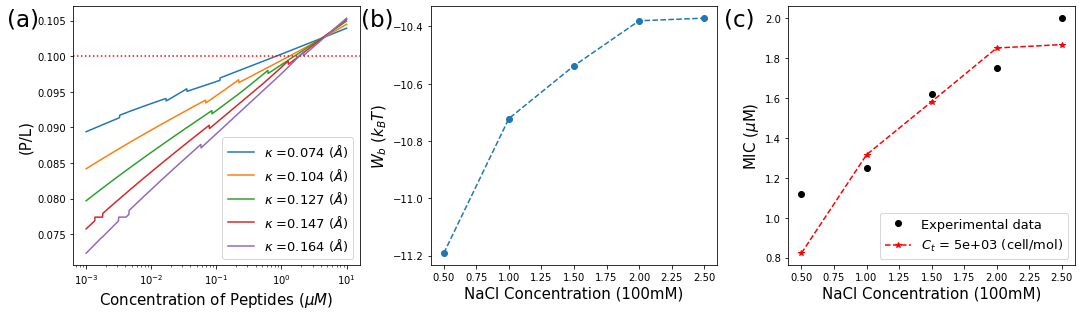

In [5]:
BE_wB   = []
MIC_save = {'kappa': [], 'Cp':[],'Ct':[], 'P/L':[],'W_b':[]}

Cp_range = np.logspace(-3,1, num=1000) #Bulk concentration range 
PL_B = 0.1
X0 = 0.001

plt.figure(figsize=(15,4.5))#,dpi=1500)
ax1 = plt.subplot(1,3,1)
for kappa in kappa_range:
    Ct_cell = 5*10**(3)
    P_LI    = []
    for Cp_val in Cp_range:
        Cp = Cp_val*((1e-6)*NA*(1e-27));
        Ct = Ct_cell *1e-24;
        x1= free_energy(Cp, Ct, X0)
        P_LI.append(x1*a0)

    P_LI = np.asarray(P_LI)
    idx = (np.abs(P_LI - PL_B)).argmin()
    W_b = binding_E_wB(Cp_range[idx] ,Ct, P_LI[idx])
    BE_wB.append(W_b)
    print('MIC: Kappa = ',kappa ,'Cp = ',Cp_range[idx],' P/L = ',P_LI[idx], ' W_b = ',W_b)

    MIC_save['kappa'].append(kappa)
    MIC_save['Cp'].append(Cp_range[idx])
    MIC_save['Ct'].append(Ct_cell)
    MIC_save['P/L'].append(P_LI[idx])
    MIC_save['W_b'].append(W_b)

    plt.plot(Cp_range,P_LI,label=r'$\kappa$ =%1.3f $({\AA})$'%kappa)    
plt.xscale('log')
plt.axhline(y=PL_B, color='r', linestyle=':')
plt.ylabel('(P/L)', fontsize = 15)
plt.xlabel('Concentration of Peptides ($\mu M$)', fontsize = 15)
plt.legend( fontsize = 13)    
plt.text(-0.23,.925,"(a)",fontsize=23, transform=ax1.transAxes)
    
ax2 = plt.subplot(1,3,2)
plt.plot(NaCl_initial,BE_wB,'--o')
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
plt.ylabel('$W_b$ $(k_B T)$', fontsize = 15)
plt.text(-0.245,.925,"(b)",fontsize=23, transform=ax2.transAxes)


# Langmuir model mapping
A_p = 400           #Amstrong square
v_p = 33**3         #Amstrong cube
A_B = 400           #Amstrong square (Surface area of each cells)
A_H = A_B        #Amstrong square
a_B = 71            #Amstrong square (Area of each lipids)
a_H = 74             #Angstrom square 
A_t = 12*10**8 #Ah and Ab
At = 12*10**8 #Ah and Ab

# Priminary Constant values
avo_con = 6.023*10**23 #Avogadro constant ==> 6.022 × 10^23 mol^(-1)
mu_M_unit = 10**-6*avo_con *10**-27
unit =10**-24 #(unit conversion)

def MIC_non_competitive_membrane(CB, w_B, PL_B):    

    MIC_0 = 1/v_p* A_B/a_B * PL_B /(1-  A_B/a_B * PL_B)*(np.exp(w_B))
    eq1   = (PL_B*At/a_B ) *CB*unit +  MIC_0
    Cp    = eq1/mu_M_unit
    
    return Cp

# Combine Sattar's Data with different salt concentrations:
ax3 = plt.subplot(1,3,3)

plt.plot(NaCl,MIC_NaCl,'o',label='Experimental data',color='k')

CB_range = [5*10**(i) for i in range(3,5,2)]
for CB in CB_range: 
    MIC_values=[]
    for i, w_B in enumerate(MIC_save['W_b']):
        MIC_values.append(MIC_non_competitive_membrane(CB,w_B,PL_B))
    plt.plot(NaCl_initial, MIC_values,'--',label=r'$C_t$ = %1.0e (cell/mol)'%(CB), marker='*',color='red')
    plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
    plt.ylabel('MIC ($\mu$M)', fontsize = 15)
plt.legend( fontsize = 13,loc='lower right')    
plt.text(-0.225,.925,"(c)",fontsize=23, transform=ax3.transAxes)    
    
plt.tight_layout()
plt.savefig('plots/'+('Outer_layer_PL_01_minimization')+'.pdf',bbox_inches='tight')


